# `MITWindfarm` Overview

`MITWindfarm` is a steady-state wake solver, which couples aerodynamic rotor models based on momentum theory with turbulent far-wake models. Furthermore, rotor models can couple to blade-element momentum (BEM) theory to output realistic set points of pitch, tip-speed ratio, and yaw for wind turbine control.

This tutorial will walk through setting up various run scenarios in order to gain familiarity with `MITWindfarm`'s main functionality. You will additionally learn how to use `MITRotor`, which holds the code for coupling the rotor models to BEM.

Start with installing the code from GitHub. In order to run the notebook below, you will need to install both `mitwindfarm` and `MITRotor`. Then import the code as follows:

In [21]:
import mitwindfarm as mwf
import MITRotor as mr

In [22]:
from mitwindfarm._Layout import GridLayout

We will also use a few common python packages.

In [23]:
import numpy as np
import matplotlib.pyplot as plt

## Wind Farm Layout

You can now set up the layout of your windfarm. You can create a vector for the x-coordiantes (`xs`) and y-coordinates (`ys`) of the rotor. There is also an optional z-coordinate input (`zx`), which allows you to give the rotors different elevations. If it isn't set, then the rotors are all at the same elevation.

You can also rotate a `Layout`. By default, the `Layout` is rotated around the centroid of the group of turbines, and rotated by degrees. However, rotating around the origin and rotating by radians is also possible, as seen below.

In [24]:
xs = [0, 0, 1, 1]
ys = [0, 1, 0, 1]

layout = mwf.Layout(xs, ys)
rot_centroid_layout = layout.rotate(20)  # rotated 20 degrees around the centroid of the turbines.
rot_origin_layout = layout.rotate(np.deg2rad(20), "rad", "origin")  # rotated the origin of the turbines.

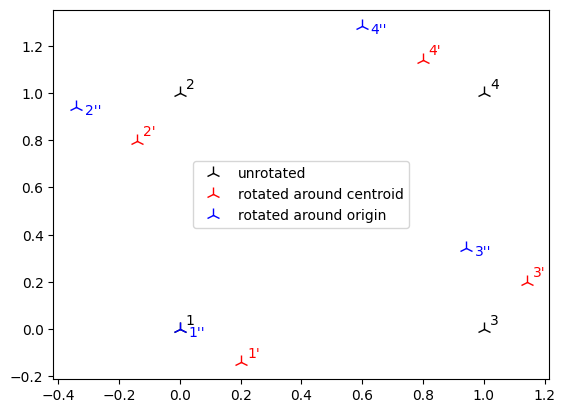

In [25]:
plt.plot(layout.x, layout.y, "2k", ms=10, label="unrotated")
plt.plot(rot_centroid_layout.x, rot_centroid_layout.y, "2r", ms=10, label="rotated around centroid")
plt.plot(rot_origin_layout.x, rot_origin_layout.y, "2b", ms=10, label="rotated around origin")

for i, (x, y, z) in enumerate(layout):
    plt.text(x + 0.02, y + 0.02, f"{i+1}", color = "k")

for i, (x, y, z) in enumerate(rot_centroid_layout):
    plt.text(x + 0.02, y + 0.02, f"{i+1}'", color = "r")

for i, (x, y, z) in enumerate(rot_origin_layout):
    plt.text(x + 0.03, y - 0.03, f"{i+1}''", color = "b")

plt.legend(loc = "center");

If you're interested in initializing an entire grid of turbines, you're can specify the grid layout with the `GridLayout` function. With this function, you can specify the spacing and number of turbines in both the streamwise and spanwise directions (`Sx`, `Sy`, `Nx`, and `Ny`). You can also specify a y-`offset`, which ranges between 0 and 1 (default is 0). Finally, you can specify the `shape` of the layout, which can either be `stag` or `trap` (default is `trap`). We can see two examples below. Note that these `GridLayouts` can also be rotated.

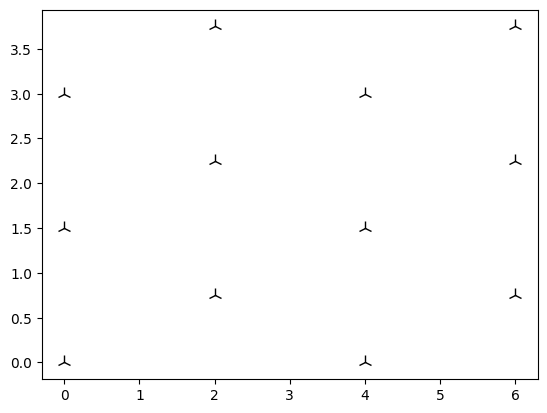

In [43]:
stag_grid_layout = GridLayout(Sx=2.0, Sy=1.5, Nx=4, Ny=3, offset = 0.5, shape="stag")
plt.plot(stag_grid_layout.x, stag_grid_layout.y, "2k", ms=10);

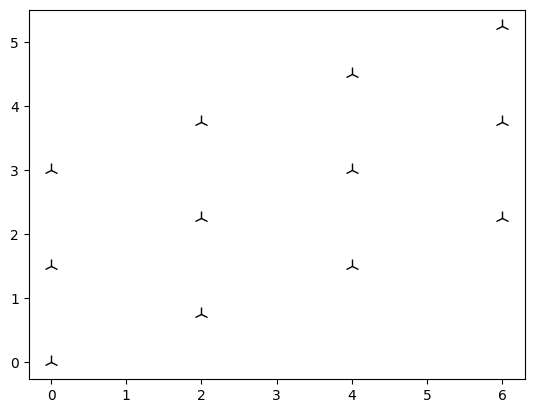

In [42]:
trap_grid_layout = GridLayout(Sx=2.0, Sy=1.5, Nx=4, Ny=3, offset = 0.5, shape="trap")
plt.plot(trap_grid_layout.x, trap_grid_layout.y, "2k", ms=10);

## Windfarm Flow Field

We can now define the flow field through the windfarm. As of now, the `WindField` class only has two main options, the `Uniform` wind field and the `PowerLaw` wind field. For the `Uniform`, the user can provide the wind speed and the ambient turbulence intensity. For the `PowerLaw`, the user must provide a refeence wind speed, as well as a height reference and exponent for the power law. They also provide the turbulence intensity.

In [45]:
uniform_wind_field = mwf.Uniform(U0 = 1.0, TIamb = 0.0)
power_law_wind_field = mwf.PowerLaw(Uref = 1.0, zref = 50.0, exp = 2.0, TIamb = 0.0) # TODO: are these reasonable even?

If a user wanted a new flow field type, the could define a new subclass, which would require a method to define the wind speed, turbulence intensity, and wind direction. Details can be found in the `Windfield.py` file. They will also find a `Superimposed` wind class, which allows the combination of existing wind fields.

## Rotor Setup

We now need to define the type of rotor model that the turbines in our farm will use. The code provides three types of rotors: `AD`, `UnifiedAD`, and `BEM`. The `AD` model is implements the model presented in Heck et al (with no correction), while the `UnifiedAD` implements the  model presented in Liew et al. The `BEM` implementation interfaces with `MITRotor`. We first explain how to use the `AD` and `UnifiedAD` classes before further discussing the how to use the `BEM` class.

### Actuator Disk Models

For the `AD` model, the only parameter is an optional `RotorGrid`. If none is provided, then it will default to a polar grid with 10 points along the radial direction and 10 angle increments around rotor. However, the user can also specify a polar rotor grid with more grid points. This polar grid is initialized by the `Area` function.

In [48]:
coarse_rotor_grid = mwf.Area()
fine_rotor_grid = mwf.Area(r_disc = 40, theta_disc= 40)

There are also `Point` and `Line` grids, which define the grid as a single point at the rotor center, or as a line across the rotor.

Once the user has created a `RotorGrid`, or decided to use the default, an actuator disk model can be created. 

### Blade Element Models and MITRotor

In [28]:
from mitwindfarm import Layout, Superposition, RotorSolution, GaussianWakeModel, Uniform, AD, Layout, UnifiedAD, BEM
from mitwindfarm import Plotting, Windfarm, Layout

In [29]:
from MITRotor.ReferenceTurbines import IEA15MW
# import mitwindfarm as mwf
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [30]:
xs = [0, 1, 1, 0]
ys = [1, 1, 0, 0]

layout = Layout(xs, ys)
layout2 = layout.rotate(20)
layout

Layout(x=[0, 1, 1, 0], y=[1, 1, 0, 0])

In [31]:
windfield = Uniform()
rotor_ad = AD()
sol_ad = rotor_ad(0, 0, 0, windfield, 2, np.deg2rad(10))
sol_ad

RotorSolution(yaw=np.float64(0.17453292519943295), Cp=np.float64(0.5814758828293066), Ct=np.float64(0.8777371289021478), Ctprime=2, an=np.float64(0.3273087509318982), u4=np.float64(0.3475882216370143), v4=np.float64(-0.038104906685727115), REWS=np.float64(1.0), TI=np.float64(0.0), idx=None, extra=MomentumSolution(Ctprime=2, yaw=np.float64(0.17453292519943295), an=np.float64(0.3273087509318982), u4=np.float64(0.3475882216370143), v4=np.float64(-0.038104906685727115), x0=np.float64(inf), dp=array(0.), dp_NL=0.0, niter=7, converged=True, beta=0.0))

In [32]:
rotor_unified = UnifiedAD()
sol_unified = rotor_unified(0, 0, 0, windfield, 2, np.deg2rad(10))
sol_unified

RotorSolution(yaw=np.float64(0.17453292519943295), Cp=np.float64(0.5860795655699441), Ct=np.float64(0.8823638727218625), Ctprime=2, an=np.float64(0.3255381300615071), u4=np.float64(0.4046610833728036), v4=np.float64(-0.03830544168461471), REWS=np.float64(1.0), TI=np.float64(0.0), idx=None, extra=MomentumSolution(Ctprime=2, yaw=np.float64(0.17453292519943295), an=array([0.32553813]), u4=array([0.40466108]), v4=array([-0.03830544]), x0=array([5.69424267]), dp=array([-0.0237898]), dp_NL=array([-0.01149044]), niter=18, converged=True, beta=0.1403))

In [33]:
rotor_bem = BEM(IEA15MW())
sol_bem = rotor_bem(0, 0, 0, windfield, 0, 9, np.deg2rad(10))
sol_bem

RotorSolution(yaw=np.float64(0.17453292519943295), Cp=np.float64(0.48667704800527856), Ct=np.float64(0.7778883214838526), Ctprime=np.float64(1.6115703183359313), an=np.float64(0.2660493782073599), u4=np.float64(0.43867573652684305), v4=np.float64(-0.035004463043753625), REWS=np.float64(0.9999800001000003), TI=np.float64(0.0), idx=None, extra=BEMSolution(pitch=0, tsr=9, yaw=np.float64(0.17453292519943295), converged=True, niter=13))

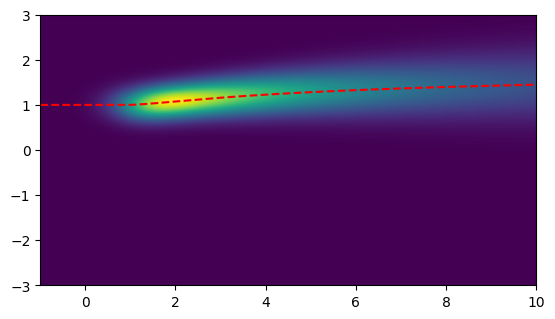

In [34]:
rotor_sol = RotorSolution(0, 0, 0, 0, 0.3, 0.5, 0.1, 1.0)

wake_model = GaussianWakeModel()
wake = wake_model(1, 1, 0, rotor_sol, TIamb=0.1)

_x, _y = np.linspace(-1, 10, 400), np.linspace(-3, 3, 400)
xmesh, ymesh = np.meshgrid(_x, _y)

deficit = wake.deficit(xmesh, ymesh)
centerline = wake.centerline(_x)

plt.imshow(deficit, extent=[_x.min(), _x.max(), _y.min(), _y.max()], origin="lower")

plt.plot(_x, centerline, "--r")

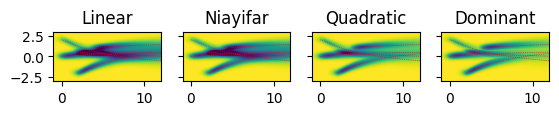

In [35]:
superposition_methods = {
    "Linear": Superposition.Linear(),
    "Niayifar":Superposition.Niayifar(),
    "Quadratic": Superposition.Quadratic(),
    "Dominant": Superposition.Dominant(),
}

layout = Layout([0, 2, 4, 2, 0], [0, 0.5, 1, -2, 2])

rotor_sols = [
    RotorSolution(0, 0, 0, 0, 0, 0.5, 0.1, 1.0),
    RotorSolution(0, 0, 0, 0, 0, 0.5, -0.1, 1.0),
    RotorSolution(0, 0, 0, 0, 0, 0.5, 0.1, 1.0),
    RotorSolution(0, 0, 0, 0, 0, 0.5, 0.5, 1.0),
    RotorSolution(0, 0, 0, 0, 0, 0.8, -0.5, 1.0),
]
wake_model = GaussianWakeModel()
wakes = [wake_model(x, y, z, sol) for (x, y, z), sol in zip(layout, rotor_sols)]

base_windfield = Uniform()

fig, axes = plt.subplots(1, len(superposition_methods), sharey=True)

_x, _y = np.linspace(-1, 12, 400), np.linspace(-3, 3, 401)
xmesh, ymesh = np.meshgrid(_x, _y)

for (label, method), ax in zip(superposition_methods.items(), axes):
    windfield = method(base_windfield, wakes)

    wsp = windfield.wsp(xmesh, ymesh, np.zeros_like(xmesh))

    ax.imshow(
        wsp,
        extent=[_x.min(), _x.max(), _y.min(), _y.max()],
        vmin=0,
        vmax=1,
        origin="lower",
    )
    for wake in wakes:
        __x = _x[_x > wake.x]
        ax.plot(__x, wake.centerline(__x), ":r", lw=0.5)

    ax.set_title(label)
    fig.subplots_adjust(hspace=0.5)

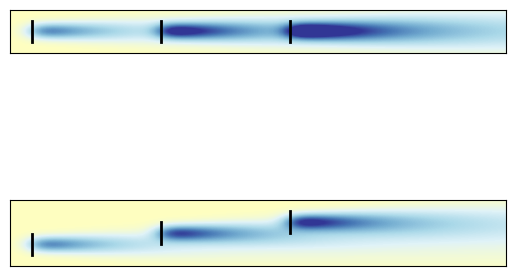

In [36]:
windfarm = Windfarm(rotor_model=BEM(IEA15MW()))

setpoints = [
    (0, 7, 0),
    (0, 7, 0),
    (0, 7, 0),
]


layout = Layout([0, 12 / 2, 24 / 2], [0, 0, 0])

windfarm_sol = windfarm(layout, setpoints)
windfarm_sol_rotated = windfarm(layout.rotate(5), setpoints)

fig, axes = plt.subplots(2)
Plotting.plot_windfarm(windfarm_sol, axes[0])
Plotting.plot_windfarm(windfarm_sol_rotated, axes[1])